In [1]:
import numpy as np
import cv2
import os
import gc
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from utils.masks import get_unet_mask, get_max_yolo_roi, filter_unet_mask_with_yolo
from utils.metrics import calculate_iou, calculate_recall, calculate_precision, calculate_dice, calculate_f1, calculate_map50, calculate_mcc, calculate_tnr

def calculate_metrics_per_frame(original_video_path, mask_video_path, Unet, max_frames=60):
    iou_list = []
    recall_list = []
    precision_list = []
    
    original_cap = cv2.VideoCapture(original_video_path)
    mask_cap = cv2.VideoCapture(mask_video_path)
    
    frame_count = 0
    while original_cap.isOpened() and mask_cap.isOpened() and frame_count < max_frames:
        ret_original, frame_original = original_cap.read()
        ret_mask, mask_frame = mask_cap.read()
        
        if not ret_original or not ret_mask:
            break

        predicted_mask = get_unet_mask(frame_original, Unet)
        ground_truth_mask = mask_frame[:, :, 0] > 127  # Convertir máscara a binario

        iou = calculate_iou(ground_truth_mask, predicted_mask)
        recall = calculate_recall(ground_truth_mask, predicted_mask)
        precision = calculate_precision(ground_truth_mask, predicted_mask)

        iou_list.append(iou)
        recall_list.append(recall)
        precision_list.append(precision)

        frame_count += 1

    original_cap.release()
    mask_cap.release()
    
    return iou_list, recall_list, precision_list


def evaluate_and_plot_hybrid_model(video_path, mask_video_path, yolo_model, unet_model, margin=15):
    hybrid_ious = []
    hybrid_recalls = []
    hybrid_precisions = []
    
    # Abrir el video y el video de máscaras
    video_cap = cv2.VideoCapture(video_path)
    mask_cap = cv2.VideoCapture(mask_video_path)

    roi = get_max_yolo_roi(video_path, yolo_model, margin)
    
    frame_count = 0
    while video_cap.isOpened() and mask_cap.isOpened() and frame_count < 60:
        ret_video, frame_video = video_cap.read()
        ret_mask, frame_mask = mask_cap.read()

        if not ret_video or not ret_mask:
            break

        # Convertir el frame de la máscara a binario (blanco es la glotis)
        ground_truth_mask = frame_mask[:, :, 0] > 127

        # Obtener la máscara de UNet y filtrarla con la ROI de YOLO
        unet_mask = get_unet_mask(frame_video, unet_model)
    
        filtered_mask = filter_unet_mask_with_yolo(unet_mask, roi)

        # Redimensionar la máscara filtrada a las dimensiones de la máscara de referencia
        filtered_mask_resized = cv2.resize(filtered_mask.astype(np.uint8), (ground_truth_mask.shape[1], ground_truth_mask.shape[0])).astype(bool)

        # Calcular las métricas
        iou_hybrid = calculate_iou(ground_truth_mask, filtered_mask_resized)
        recall_hybrid = calculate_recall(ground_truth_mask, filtered_mask_resized)
        precision_hybrid = calculate_precision(ground_truth_mask, filtered_mask_resized)

        # Almacenar las métricas
        hybrid_ious.append(iou_hybrid)
        hybrid_recalls.append(recall_hybrid)
        hybrid_precisions.append(precision_hybrid)

        frame_count += 1

        # Liberar recursos
        del ground_truth_mask
        del filtered_mask_resized
        if frame_count % 100 == 0:
            gc.collect()
            tf.keras.backend.clear_session()

    video_cap.release()
    mask_cap.release()

    return hybrid_ious, hybrid_recalls, hybrid_precisions


def plot_combined_metrics(video_path, mask_video_path, yolo_model, unet_model, frames=60):
    # Calcular métricas para UNet
    iou_unet, recall_unet, precision_unet = calculate_metrics_per_frame(video_path, mask_video_path, unet_model, frames)
    
    # Calcular métricas para el modelo híbrido
    iou_hybrid, recall_hybrid, precision_hybrid = evaluate_and_plot_hybrid_model(video_path, mask_video_path, yolo_model, unet_model, margin=15)

    # Graficar las métricas combinadas
    frame_indices = range(1, len(iou_unet) + 1)

    plt.figure(figsize=(6, 8))  # Ajuste del tamaño del gráfico

    # Gráfico de IoU
    plt.subplot(3, 1, 1)
    plt.plot(frame_indices, iou_unet, label="UNet", color='black', linestyle='--', linewidth=1)
    plt.plot(frame_indices, iou_hybrid, label="Combinado", color='green', linestyle='-', linewidth=1)

    plt.axvline(x=31, color='red', linestyle='-', linewidth=1)
    plt.axvline(x=42, color='red', linestyle='-', linewidth=1)
    plt.axvline(x=25, color='red', linestyle='-', linewidth=1)

    xticks = sorted(set(np.arange(1, len(frame_indices) + 1, 5).tolist() + [25, 31, 42]))
    plt.xticks(xticks, fontsize=8)
    
    plt.xlabel("Frame", fontsize=10)
    plt.ylabel("IoU", fontsize=10)
    plt.xticks(np.arange(0, len(frame_indices), 10), fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(fontsize=8, loc='best')
    
    # Gráfico de Recall
    plt.subplot(3, 1, 2)
    plt.plot(frame_indices, recall_unet, label="UNet", color='black', linestyle='--', linewidth=1)
    plt.plot(frame_indices, recall_hybrid, label="Combinado", color='green', linestyle='-', linewidth=1)
    plt.xlabel("Frame", fontsize=10)
    plt.ylabel("Recall", fontsize=10)
    plt.xticks(np.arange(0, len(frame_indices) + 1, 10), fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(fontsize=8, loc='best')

    # Gráfico de Precision
    plt.subplot(3, 1, 3)
    plt.plot(frame_indices, precision_unet, label="UNet", color='black', linestyle='--', linewidth=1)
    plt.plot(frame_indices, precision_hybrid, label="Híbrido", color='green', linestyle='-', linewidth=1)
    plt.xlabel("Frame", fontsize=10)
    plt.ylabel("Precision", fontsize=10)
    plt.xticks(np.arange(0, len(frame_indices) + 1, 10), fontsize=8)
    plt.yticks(fontsize=8)
    plt.legend(fontsize=8, loc='best')

    plt.tight_layout()
    plt.show()



2024-09-26 16:50:57.974780: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 16:50:57.995446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 16:50:57.995465: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 16:50:57.996058: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 16:50:57.999835: I tensorflow/core/platform/cpu_feature_guar

2024-09-26 16:51:00.083519: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 16:51:00.084223: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-26 16:51:00.084329: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

1/1 [==============================] - 0s 10ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/m

1/1 [==============================] - 0s 11ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/m

1/1 [==============================] - 0s 11ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 11ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/m

1/1 [==============================] - 0s 11ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/m

1/1 [==============================] - 0s 11ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 10ms/step

0: 640x512 1 glottis, 57.6ms
Speed: 3.2ms preprocess, 57.6ms inference, 66.6ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 2.3ms
Speed: 1.2ms preprocess, 2.3ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 2.3ms
Speed: 0.8ms preprocess, 2.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 2.0ms
Speed: 0.8ms preprocess, 2.0ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 1.9ms
Speed: 0.8ms preprocess, 1.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 1.8ms
Speed: 0.8ms preprocess, 1.8ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 5.1ms
Speed: 1.2ms preprocess, 5.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 512)

0: 640x512 (no detections), 1.8ms

/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vo

1/1 [==============================] - 0s 10ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vo

1/1 [==============================] - 0s 10ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vo

1/1 [==============================] - 0s 10ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vo

1/1 [==============================] - 0s 10ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vo

1/1 [==============================] - 0s 11ms/step


/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/voicelab/miniconda3/envs/tmpenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/vo

1/1 [==============================] - 0s 10ms/step


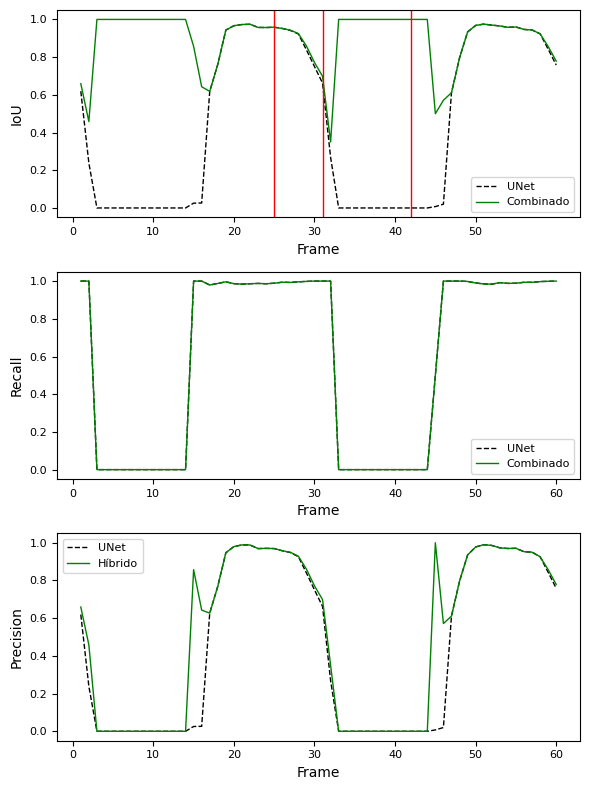

In [2]:
original_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/155.mp4"
mask_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/155_seg.mp4"
yolo_model_path = "/home/voicelab/Desktop/segmentation_glottis/YOLOV8/best_yolov8n-seg-1cls.pt"
yolo_model = YOLO(yolo_model_path)
unet_model_path = "/home/voicelab/Downloads/epoch025.h5"
unet_model = load_model(unet_model_path, compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})
plot_combined_metrics(original_video_path, mask_video_path, yolo_model, unet_model)


In [ ]:
original_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/598.mp4"
mask_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/598_seg.mp4"
unet_model_path = "/home/voicelab/Downloads/epoch025.h5"
unet_model = load_model(unet_model_path, compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})

calculate_metrics_per_frame(original_video_path, mask_video_path, unet_model)

In [ ]:
original_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/155.mp4"
mask_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/155_seg.mp4"
unet_model_path = "/home/voicelab/Downloads/epoch025.h5"
unet_model = load_model(unet_model_path, compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})

calculate_metrics_per_frame(original_video_path, mask_video_path, unet_model)

In [ ]:
original_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/547.mp4"
mask_video_path = "/home/voicelab/Desktop/segmentation_glottis/BAGLS/raw/raw/547_seg.mp4"
unet_model_path = "/home/voicelab/Downloads/epoch025.h5"
unet_model = load_model(unet_model_path, compile=False, custom_objects={'InstanceNormalization': tfa.layers.InstanceNormalization})

calculate_metrics_per_frame(original_video_path, mask_video_path, unet_model)